# Theory: Locally Linear Embedding (LLE)

### Our Goal
**Locally Linear Embedding (LLE)** is an unsupervised nonlinear dimensionality-reduction algorithm we use to seek a low-dimensional embedding that preserves local geometry. Our objective is to ensure each point remains reconstructable from its neighbors in both the original and the embedding spaces.

---

### Our Main Idea (3-Step Process)
Given our dataset $X = \{x_i\} \subset \mathbb{R}^D$, we follow these steps:

1.  **Identify Neighbors:** For each point $x_i$, we find its $k$ nearest neighbors.
2.  **Compute Reconstruction Weights:** We solve for weights $w_{ij}$ that minimize our local reconstruction error:
    $$\sum_i \left\| x_i - \sum_{j \in N(i)} w_{ij} x_j \right\|^2$$
    *Subject to the constraint:* $\sum_j w_{ij} = 1$. This allows us to perform a small linear least-squares optimization for each point.
3.  **Map to Low-Dimensional Space:** We find embedding coordinates $y_i \in \mathbb{R}^d$ that best preserve our calculated weights by minimizing:
    $$\sum_i \left\| y_i - \sum_{j \in N(i)} w_{ij} y_j \right\|^2$$
    This step reduces to an eigenproblem on a sparse matrix $M = (I - W)^T(I - W)$. We take the bottom eigenvectors (excluding the trivial constant vector) to form our embedding.

---

### Why Our Approach Works
We exploit **local linearity**. Locally, we assume the manifold looks like a linear subspace; therefore, our linear reconstruction weights effectively capture the local geometry. By enforcing these same weights in the embedding, we allow the global structure to emerge naturally.

# Main Parameters & Heuristics

When we implement LLE (via `scikit-learn` or similar libraries), we focus on several key hyperparameters to tune our results.

### Key Hyperparameters

| Parameter | Our Usage & Heuristics |
| :--- | :--- |
| **`n_neighbors` ($k$)** | **Our most influential parameter.** It controls locality: if we set it too small, our neighborhoods become noisy and fragmented; if too large, nonlocal smoothing may destroy the manifold structure. *Typical range:* 5–30 (set relative to our sample density). |
| **`n_components` ($d$)** | Our target embedding dimensionality. We pick this based on our visualization needs (2 or 3) or our estimates of the data's intrinsic dimensionality. |
| **`reg`** | The regularization we add to local covariance when solving for weights. This is crucial when our neighborhood matrix is singular or ill-conditioned. We should raise this if our linear system becomes unstable. |
| **`method`** | We can choose between `'standard'`, `'modified'`, `'ltsa'`, or `'hessian'`. For example, we use **Hessian** for better local curvature capture, while **Modified LLE** helps us achieve better stability. |
| **`eigen_solver`** | Controls our eigen-decomposition. For our larger datasets, we prefer sparse solvers like `arpack`, though we must monitor them for numerical instability. |

---

### Our Heuristic Tips for Success

* **Prioritize $k$:** We should tune `n_neighbors` first, as it has the greatest impact on the embedding quality.
* **Stability:** If we find our embedding is noisy or produces singular matrices, we should increase our `reg` or `n_neighbors`.
* **Noisy Data:** For datasets with significant noise, we should consider using `method='modified'` or preprocessing our data (e.g., denoising or applying PCA first).

# Quick Scikit-Learn Demo: LLE on Hand-written Digits

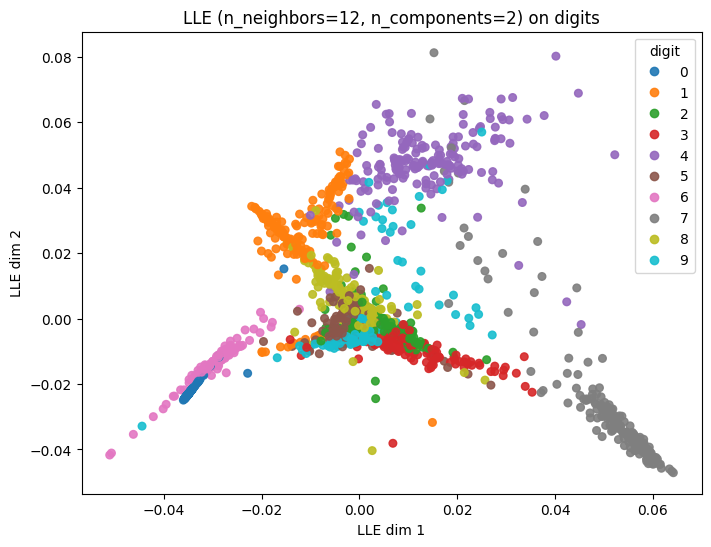

In [1]:
# lle_digits_demo.py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.preprocessing import StandardScaler

# load data
digits = load_digits()
X, y = digits.data, digits.target

# scale (optional but usually helpful)
X = StandardScaler().fit_transform(X)

# LLE projection
lle = LocallyLinearEmbedding(n_neighbors=12, n_components=2, method='standard', random_state=42)
X_lle = lle.fit_transform(X)   # shape (n_samples, 2)

# simple scatter
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_lle[:,0], X_lle[:,1], c=y, cmap='tab10', s=30, alpha=0.9)
plt.legend(*scatter.legend_elements(), title="digit")
plt.title("LLE (n_neighbors=12, n_components=2) on digits")
plt.xlabel("LLE dim 1")
plt.ylabel("LLE dim 2")
plt.grid(False)
plt.show()


# Pipeline & Hyperparameter Tuning

When we use LLE as a preprocessing step for classification, it is critical that we **fit the LLE only on our training folds**. By using a `Pipeline`, we ensure that LLE is recalculated inside the Cross-Validation (CV) loop, preventing "data leakage" from our test sets.

### Our Implementation Strategy
We will combine LLE with a Random Forest Classifier using `Pipeline` and then use `GridSearchCV` to find the optimal number of neighbors ($k$).

In [2]:
# lle_pipeline_gridsearch.py
import numpy as np
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# load dataset
X, y = load_iris(return_X_y=True)

# pipeline: scaler -> LLE -> classifier
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lle', LocallyLinearEmbedding(random_state=0)),   # params to tune
    ('clf', RandomForestClassifier(random_state=0))
])

# grid of hyperparams (note: be conservative with methods that have constraints)
param_grid = {
    'lle__n_neighbors': [5, 10, 15],
    'lle__n_components': [2, 3],          # for Iris, 2 or 3
    'lle__reg': [1e-3, 1e-2],
    'lle__method': ['standard', 'modified'],
    'clf__n_estimators': [100],           # keep classifier grid small to save time
}

# GridSearchCV (5-fold)
gs = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
gs.fit(X, y)

print("best score:", gs.best_score_)
print("best params:", gs.best_params_)

# After best found, we can inspect the embedding learned on full training data:
best_pipe = gs.best_estimator_
X_embedded = best_pipe.named_steps['lle'].fit_transform(best_pipe.named_steps['scaler'].transform(X))
print("embedded shape:", X_embedded.shape)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
best score: 0.9133333333333333
best params: {'clf__n_estimators': 100, 'lle__method': 'standard', 'lle__n_components': 3, 'lle__n_neighbors': 5, 'lle__reg': 0.01}
embedded shape: (150, 3)


# Important Note on Cross-Validation (CV)

When we work with manifold learning like LLE, we must be extremely careful about **Data Leakage**.

### Our Core Principle
Because LLE is an unsupervised method that relies on the global structure of the input data, we must ensure it only "sees" the training data. Using a `Pipeline` handles this automatically:

* **Inside the Pipeline:** `GridSearchCV` will fit our LLE transformer **only** on the training folds.
* **Preventing Leakage:** We must avoid calling `lle.fit_transform()` on our entire dataset before starting Cross-Validation. If we do, the local neighborhood structure of our test set will influence the training process, leading to over-optimistic (and incorrect) results.



---

### Our Workflow Check
| Action | Status | Why? |
| :--- | :--- | :--- |
| **Use `Pipeline`** | ✅ Recommended | Ensures LLE is refit on every training fold independently. |
| **`fit_transform` whole data** | ❌ Avoid | Leaks our test set distribution into our training process. |
| **StandardScaler first** | ✅ Recommended | LLE is distance-based; we should scale our features so they contribute equally. |

> For more details on how our transformers interact with CV, we can refer to the official [scikit-learn documentation on Pipelines](https://scikit-learn.org/stable/modules/compose.html#pipeline).

# What to Consider: Bias, Variance, & Failure Modes

Before we finalize our embedding strategy, we must evaluate the trade-offs of LLE. Understanding when our model might fail helps us build more robust pipelines for our data.

---

### Our Bias vs. Variance Intuition
Managing the balance between underfitting and overfitting in LLE primarily comes down to our choice of $k$ (neighbors).

* **Bias (Underfitting):** If we set `n_neighbors` too large relative to the local manifold curvature, our neighborhoods are no longer "local." The embedding smooths away important structural details. Similarly, choosing `n_components` too low forces heavy compression, causing us to lose essential coordinates.
* **Variance (Overfitting):** If we set `n_neighbors` too small or our data is noisy, our local linear fits become unstable. In this case, our embeddings will vary significantly with even small perturbations in the data.

**Our Trade-off Guide:** We should start with a moderate $k$ (e.g., 8–15), then check our embeddings visually and via downstream metrics (like our CV accuracy). We use `reg` (regularization) to reduce variance caused by ill-conditioning.



---

### Failure Modes & Limitations
We should be aware of these specific scenarios where LLE might struggle:

1.  **No Natural Out-of-Sample Map:** LLE learns coordinates specifically for our training points. While scikit-learn provides a `transform` method, out-of-sample mapping is often approximate. If we need a fast, explicit transform for new data, we might consider **Kernel PCA** or **Autoencoders**.
2.  **Sensitivity to Noise:** Outliers can corrupt our neighborhoods. We should use denoising, robust preprocessing, or **Modified-LLE** to mitigate this.
3.  **Sampling Density:** If our data sampling is highly non-uniform or the manifold is disconnected/self-intersecting, LLE can produce misleading results.
4.  **Computational Cost:** LLE is heavier than PCA because it solves many local least-squares problems and a global sparse eigenproblem.

---

### Our Practical Checklist
Before we integrate LLE into our final pipeline, we should follow these steps:

* **Standardize Features:** Since LLE is distance-based, we must scale our features so they contribute equally.
* **Inspect Connectivity:** Visualize our $k$-Nearest Neighbor (kNN) graphs to ensure our $k$ is sufficient for a connected structure.
* **Start Simple:** Try PCA first. If linear reduction already separates our structure, it is cheaper and more stable than LLE.
* **Validate via CV:** Use our `Pipeline` to ensure LLE is fit within CV folds to prevent leakage.
* **Plan for New Data:** If our project requires mapping novel points frequently, we should evaluate if we need Nyström approximations or a different algorithm.

